# First contact with the dataset
This Notebook has as objective to replicate the baseline results from Minixhofer et al. (2021)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter



**Note :** Just to have a normalized methodology to save and visualize the results of all the experiments trought this projet I add and configure a Tensorboard-SummaryWriter. In the same way I have changed the training cycle to put the results in the tensorboard format.

In [34]:
writer = SummaryWriter('../logs/LSTM_Minixhofer')

## Importing the data in a unique dictionary

In [35]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [36]:
dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
           "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
           "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
           "soil" : pd.read_csv("../src/soil_data.csv"),
           }


In [37]:
dataDic["train"].columns

Index(['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score'],
      dtype='object')

In [38]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [39]:
dfs = {
    k: dataDic[k].set_index(['fips', 'date'])
    for k in dataDic.keys() if k != "soil"
}

dfs["soil"] = dataDic["soil"]

In [40]:
dfs["train"]

PRECTOT      PS   QV2M  ...  WS50M_MIN  WS50M_RANGE  score
fips  date                                ...                               
1001  2000-01-01     0.22  100.51   9.65  ...       3.23         2.81    NaN
      2000-01-02     0.20  100.55  10.42  ...       3.72         2.41    NaN
      2000-01-03     3.65  100.15  11.76  ...       5.87         3.66    NaN
      2000-01-04    15.95  100.29   6.42  ...       3.74         5.58    1.0
      2000-01-05     0.00  101.15   2.95  ...       0.65         4.19    NaN
...                   ...     ...    ...  ...        ...          ...    ...
56043 2016-12-27     0.16   82.88   1.63  ...       5.92         4.47    0.0
      2016-12-28     0.02   83.33   1.41  ...       7.26         7.22    NaN
      2016-12-29     0.00   83.75   1.59  ...       3.20         6.87    NaN
      2016-12-30     1.22   82.49   2.63  ...       3.24         6.89    NaN
      2016-12-31     0.44   82.19   1.75  ...       0.66         4.60    NaN

[19300680 rows x 19 columns]

## Interpolation pour les données manquantes

In [41]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

## Function to encode the cycling feature: year-day, using sin/cos

In [42]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

## Function to load the data

In [43]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [44]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [45]:
# X_tabular_train, X_time_train, y_target_train = loadXY("train")
# print("train shape", X_time_train.shape)
# X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True)
# print("validation shape", X_time_valid.shape)
# X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True)
# print("test shape", X_time_test.shape)
# X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
# X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)
# X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

# # export all
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy", X_tabular_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_train.npy", X_time_train)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_train.npy", y_target_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy", X_tabular_validation)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_valid.npy", X_time_valid)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_valid.npy", y_target_valid)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy", X_tabular_test)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_test.npy", X_time_test)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_test.npy", y_target_test)
# np.save("../data/processed_no_cat_and_no_tensors/valid_fips.npy", valid_fips)
# np.save("../data/processed_no_cat_and_no_tensors/test_fips.npy", test_fips)

In [46]:
# import all
import pickle
# import all
X_tabular_train = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy")
X_time_train = np.load("../data/processed_no_cat_and_no_tensors/X_time_train.npy")
y_target_train = np.load("../data/processed_no_cat_and_no_tensors/y_target_train.npy")
X_tabular_validation = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy")
X_time_valid = np.load("../data/processed_no_cat_and_no_tensors/X_time_valid.npy")
y_target_valid = np.load("../data/processed_no_cat_and_no_tensors/y_target_valid.npy")
X_tabular_test = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy")
X_time_test = np.load("../data/processed_no_cat_and_no_tensors/X_time_test.npy")
y_target_test = np.load("../data/processed_no_cat_and_no_tensors/y_target_test.npy")
with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "rb") as f:
    valid_fips = pickle.load(f)
with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "rb") as f:
    test_fips = pickle.load(f)


In [47]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
one_cycle = True
lr = 7e-5
epochs = 10
clip = 5

In [48]:
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    torch.tensor(y_target_train[:, :output_weeks]),
)
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=False
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(y_target_valid[:, :output_weeks]),
)
valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

test_data = TensorDataset(
    torch.tensor(X_time_test),
    torch.tensor(X_tabular_test),
    torch.tensor(y_target_test[:, :output_weeks]),
)
test_loader = DataLoader(
    test_data, shuffle=False, batch_size=batch_size, drop_last=False
)


In [49]:
class DroughtNetLSTM(nn.Module):
    def __init__(
        self,
        output_size,
        num_input_features,
        hidden_dim,
        n_layers,
        ffnn_layers,
        drop_prob,
        static_dim=0,
    ):
        super(DroughtNetLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(
            num_input_features,
            hidden_dim,
            n_layers,
            dropout=drop_prob,
            batch_first=True,
        )
        self.dropout = nn.Dropout(drop_prob)
        self.fflayers = []
        for i in range(ffnn_layers - 1):
            if i == 0:
                self.fflayers.append(nn.Linear(hidden_dim + static_dim, hidden_dim))
            else:
                self.fflayers.append(nn.Linear(hidden_dim, hidden_dim))
        self.fflayers = nn.ModuleList(self.fflayers)
        self.final = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, static=None):
        batch_size = x.size(0)
        x = x.to(dtype=torch.float32)
        if static is not None:
            static = static.to(dtype=torch.float32)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]

        out = self.dropout(lstm_out)
        for i in range(len(self.fflayers)):
            if i == 0 and static is not None:
                out = self.fflayers[i](torch.cat((out, static), 1))
            else:
                out = self.fflayers[i](out)
        out = self.final(out)

        out = out.view(batch_size, -1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [50]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")
static_dim = 0
if use_static:
    static_dim = X_tabular_train.shape[-1]
model = DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
)
model.to(device)
loss_function = nn.MSELoss()
if one_cycle:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs
    )
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)
for i in range(epochs):
    h = model.init_hidden(batch_size)

    for k, (inputs, static, labels) in tqdm(
        enumerate(train_loader),
        desc=f"epoch {i+1}/{epochs}",
        total=len(train_loader),
    ):
        model.train()
        counter += 1
        if len(inputs) < batch_size:
            h = model.init_hidden(len(inputs))
        h = tuple([e.data for e in h])
        inputs, labels, static = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
        )
        model.zero_grad()
        if use_static:
            output, h = model(inputs, h, static)
        else:
            output, h = model(inputs, h)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if one_cycle:
            scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, lab in valid_loader:
                    if len(inp) < batch_size:
                        val_h = model.init_hidden(len(inp))
                    val_h = tuple([each.data for each in val_h])
                    inp, lab, stat = inp.to(device), lab.to(device), stat.to(device)
                    if use_static:
                        out, val_h = model(inp, val_h, stat)
                    else:
                        out, val_h = model(inp, val_h)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(MSE)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "./state_dict.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/10:  50%|█████     | 404/808 [02:27<27:09,  4.03s/it]

{'loss': 0.43439003825187683, 'epoch': 0.5, 'step': 404, 'lr': 7.305177512317032e-06, 'week': 1, 'validation_loss': np.float64(0.4371506925942241), 'macro_f1': np.float64(0.48205011197760994), 'micro_f1': np.float64(0.710448102423411), 'mae': np.float64(0.4276641628992643)}
{'loss': 0.43439003825187683, 'epoch': 0.5, 'step': 404, 'lr': 7.305177512317032e-06, 'week': 2, 'validation_loss': np.float64(0.4371506925942241), 'macro_f1': np.float64(0.4181413782460704), 'micro_f1': np.float64(0.6366026520347507), 'mae': np.float64(0.497252195817767)}
{'loss': 0.43439003825187683, 'epoch': 0.5, 'step': 404, 'lr': 7.305177512317032e-06, 'week': 3, 'validation_loss': np.float64(0.4371506925942241), 'macro_f1': np.float64(0.37398949204965565), 'micro_f1': np.float64(0.6047096479195244), 'mae': np.float64(0.5146952694218605)}
{'loss': 0.43439003825187683, 'epoch': 0.5, 'step': 404, 'lr': 7.305177512317032e-06, 'week': 4, 'validation_loss': np.float64(0.4371506925942241), 'macro_f1': np.float64(0.35

epoch 1/10: 100%|██████████| 808/808 [04:54<00:00,  2.74it/s]


{'loss': 0.22111700475215912, 'epoch': 1.0, 'step': 808, 'lr': 1.9612577643465342e-05, 'week': 1, 'validation_loss': np.float64(0.2489694458418998), 'macro_f1': np.float64(0.759821187347011), 'micro_f1': np.float64(0.8667123914037494), 'mae': np.float64(0.22096670911482358)}
{'loss': 0.22111700475215912, 'epoch': 1.0, 'step': 808, 'lr': 1.9612577643465342e-05, 'week': 2, 'validation_loss': np.float64(0.2489694458418998), 'macro_f1': np.float64(0.6782367996250347), 'micro_f1': np.float64(0.813328760859625), 'mae': np.float64(0.27273836228820225)}
{'loss': 0.22111700475215912, 'epoch': 1.0, 'step': 808, 'lr': 1.9612577643465342e-05, 'week': 3, 'validation_loss': np.float64(0.2489694458418998), 'macro_f1': np.float64(0.6302650511885216), 'micro_f1': np.float64(0.7770919067215364), 'mae': np.float64(0.31942023256549895)}
{'loss': 0.22111700475215912, 'epoch': 1.0, 'step': 808, 'lr': 1.9612577643465342e-05, 'week': 4, 'validation_loss': np.float64(0.2489694458418998), 'macro_f1': np.float64

epoch 2/10:  50%|█████     | 404/808 [02:28<26:35,  3.95s/it]

{'loss': 0.3071940541267395, 'epoch': 1.5, 'step': 1212, 'lr': 3.6421782399043904e-05, 'week': 1, 'validation_loss': np.float64(0.23673295747974646), 'macro_f1': np.float64(0.7873410804581963), 'micro_f1': np.float64(0.8812299954275263), 'mae': np.float64(0.19066162096704686)}
{'loss': 0.3071940541267395, 'epoch': 1.5, 'step': 1212, 'lr': 3.6421782399043904e-05, 'week': 2, 'validation_loss': np.float64(0.23673295747974646), 'macro_f1': np.float64(0.7006700865982726), 'micro_f1': np.float64(0.8265889346136259), 'mae': np.float64(0.24354855869290934)}
{'loss': 0.3071940541267395, 'epoch': 1.5, 'step': 1212, 'lr': 3.6421782399043904e-05, 'week': 3, 'validation_loss': np.float64(0.23673295747974646), 'macro_f1': np.float64(0.6502549613514462), 'micro_f1': np.float64(0.7857796067672611), 'mae': np.float64(0.29618675958483826)}
{'loss': 0.3071940541267395, 'epoch': 1.5, 'step': 1212, 'lr': 3.6421782399043904e-05, 'week': 4, 'validation_loss': np.float64(0.23673295747974646), 'macro_f1': np.f

epoch 2/10: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.23621000349521637, 'epoch': 2.0, 'step': 1616, 'lr': 5.322514587043574e-05, 'week': 1, 'validation_loss': np.float64(0.22760890526832014), 'macro_f1': np.float64(0.6298390739150745), 'micro_f1': np.float64(0.8741426611796982), 'mae': np.float64(0.17778785903860392)}
{'loss': 0.23621000349521637, 'epoch': 2.0, 'step': 1616, 'lr': 5.322514587043574e-05, 'week': 2, 'validation_loss': np.float64(0.22760890526832014), 'macro_f1': np.float64(0.5603733454331237), 'micro_f1': np.float64(0.8233882030178327), 'mae': np.float64(0.23247357375398756)}
{'loss': 0.23621000349521637, 'epoch': 2.0, 'step': 1616, 'lr': 5.322514587043574e-05, 'week': 3, 'validation_loss': np.float64(0.22760890526832014), 'macro_f1': np.float64(0.4638597375923444), 'micro_f1': np.float64(0.7780064014631916), 'mae': np.float64(0.28885399813717927)}
{'loss': 0.23621000349521637, 'epoch': 2.0, 'step': 1616, 'lr': 5.322514587043574e-05, 'week': 4, 'validation_loss': np.float64(0.22760890526832014), 'macro_f1': np.f

epoch 3/10:  50%|█████     | 404/808 [02:28<26:50,  3.99s/it]

{'loss': 0.2470657229423523, 'epoch': 2.5, 'step': 2020, 'lr': 6.551658857891442e-05, 'week': 1, 'validation_loss': np.float64(0.2289412185225798), 'macro_f1': np.float64(0.710560307706163), 'micro_f1': np.float64(0.8847736625514403), 'mae': np.float64(0.17197577764236738)}
{'loss': 0.2470657229423523, 'epoch': 2.5, 'step': 2020, 'lr': 6.551658857891442e-05, 'week': 2, 'validation_loss': np.float64(0.2289412185225798), 'macro_f1': np.float64(0.6331633576570277), 'micro_f1': np.float64(0.8273891175125743), 'mae': np.float64(0.23403836070341563)}
{'loss': 0.2470657229423523, 'epoch': 2.5, 'step': 2020, 'lr': 6.551658857891442e-05, 'week': 3, 'validation_loss': np.float64(0.2289412185225798), 'macro_f1': np.float64(0.5948921340805309), 'micro_f1': np.float64(0.7839506172839507), 'mae': np.float64(0.2951838644649222)}
{'loss': 0.2470657229423523, 'epoch': 2.5, 'step': 2020, 'lr': 6.551658857891442e-05, 'week': 4, 'validation_loss': np.float64(0.2289412185225798), 'macro_f1': np.float64(0.5

epoch 3/10: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.25792092084884644, 'epoch': 3.0, 'step': 2424, 'lr': 6.99999946009513e-05, 'week': 1, 'validation_loss': np.float64(0.22655689219633737), 'macro_f1': np.float64(0.7815743420457405), 'micro_f1': np.float64(0.8812299954275263), 'mae': np.float64(0.17221049296600574)}
{'loss': 0.25792092084884644, 'epoch': 3.0, 'step': 2424, 'lr': 6.99999946009513e-05, 'week': 2, 'validation_loss': np.float64(0.22655689219633737), 'macro_f1': np.float64(0.7062004062687027), 'micro_f1': np.float64(0.8275034293552812), 'mae': np.float64(0.23132265647516612)}
{'loss': 0.25792092084884644, 'epoch': 3.0, 'step': 2424, 'lr': 6.99999946009513e-05, 'week': 3, 'validation_loss': np.float64(0.22655689219633737), 'macro_f1': np.float64(0.6621153545731017), 'micro_f1': np.float64(0.7877229080932785), 'mae': np.float64(0.2826538064133248)}
{'loss': 0.25792092084884644, 'epoch': 3.0, 'step': 2424, 'lr': 6.99999946009513e-05, 'week': 4, 'validation_loss': np.float64(0.22655689219633737), 'macro_f1': np.float6

epoch 4/10:  50%|█████     | 404/808 [02:28<26:37,  3.95s/it]

{'loss': 0.270805299282074, 'epoch': 3.5, 'step': 2828, 'lr': 6.911814926126814e-05, 'week': 1, 'validation_loss': np.float64(0.21315411505275877), 'macro_f1': np.float64(0.7739289519399062), 'micro_f1': np.float64(0.8924325560128029), 'mae': np.float64(0.15261487065337778)}
{'loss': 0.270805299282074, 'epoch': 3.5, 'step': 2828, 'lr': 6.911814926126814e-05, 'week': 2, 'validation_loss': np.float64(0.21315411505275877), 'macro_f1': np.float64(0.6881717471361705), 'micro_f1': np.float64(0.83493369913123), 'mae': np.float64(0.21056825782785615)}
{'loss': 0.270805299282074, 'epoch': 3.5, 'step': 2828, 'lr': 6.911814926126814e-05, 'week': 3, 'validation_loss': np.float64(0.21315411505275877), 'macro_f1': np.float64(0.637004309562153), 'micro_f1': np.float64(0.7925240054869684), 'mae': np.float64(0.2644026357454708)}
{'loss': 0.270805299282074, 'epoch': 3.5, 'step': 2828, 'lr': 6.911814926126814e-05, 'week': 4, 'validation_loss': np.float64(0.21315411505275877), 'macro_f1': np.float64(0.581

epoch 4/10: 100%|██████████| 808/808 [04:56<00:00,  2.72it/s]


{'loss': 0.17041482031345367, 'epoch': 4.0, 'step': 3232, 'lr': 6.652548447282524e-05, 'week': 1, 'validation_loss': np.float64(0.20995545819185782), 'macro_f1': np.float64(0.8142677870306062), 'micro_f1': np.float64(0.8951760402377686), 'mae': np.float64(0.1581126337184257)}
{'loss': 0.17041482031345367, 'epoch': 4.0, 'step': 3232, 'lr': 6.652548447282524e-05, 'week': 2, 'validation_loss': np.float64(0.20995545819185782), 'macro_f1': np.float64(0.7033225754185621), 'micro_f1': np.float64(0.8382487425697303), 'mae': np.float64(0.2165816399845342)}
{'loss': 0.17041482031345367, 'epoch': 4.0, 'step': 3232, 'lr': 6.652548447282524e-05, 'week': 3, 'validation_loss': np.float64(0.20995545819185782), 'macro_f1': np.float64(0.6229780401943495), 'micro_f1': np.float64(0.7932098765432098), 'mae': np.float64(0.26303260468490214)}
{'loss': 0.17041482031345367, 'epoch': 4.0, 'step': 3232, 'lr': 6.652548447282524e-05, 'week': 4, 'validation_loss': np.float64(0.20995545819185782), 'macro_f1': np.flo

epoch 5/10:  50%|█████     | 404/808 [02:28<26:47,  3.98s/it]

{'loss': 0.280451238155365, 'epoch': 4.5, 'step': 3636, 'lr': 6.235200727414045e-05, 'week': 1, 'validation_loss': np.float64(0.2099910249420698), 'macro_f1': np.float64(0.8110662201223243), 'micro_f1': np.float64(0.89586191129401), 'mae': np.float64(0.13461360429603747)}
{'loss': 0.280451238155365, 'epoch': 4.5, 'step': 3636, 'lr': 6.235200727414045e-05, 'week': 2, 'validation_loss': np.float64(0.2099910249420698), 'macro_f1': np.float64(0.7341508102054043), 'micro_f1': np.float64(0.8383630544124371), 'mae': np.float64(0.19747322245027393)}
{'loss': 0.280451238155365, 'epoch': 4.5, 'step': 3636, 'lr': 6.235200727414045e-05, 'week': 3, 'validation_loss': np.float64(0.2099910249420698), 'macro_f1': np.float64(0.6695879954105055), 'micro_f1': np.float64(0.7973251028806584), 'mae': np.float64(0.2521598537668841)}
{'loss': 0.280451238155365, 'epoch': 4.5, 'step': 3636, 'lr': 6.235200727414045e-05, 'week': 4, 'validation_loss': np.float64(0.2099910249420698), 'macro_f1': np.float64(0.579643

epoch 5/10: 100%|██████████| 808/808 [04:56<00:00,  2.72it/s]


{'loss': 0.37415289878845215, 'epoch': 5.0, 'step': 4040, 'lr': 5.680699323887897e-05, 'week': 1, 'validation_loss': np.float64(0.21556484585870866), 'macro_f1': np.float64(0.8232080319774665), 'micro_f1': np.float64(0.9005486968449932), 'mae': np.float64(0.13709590178202882)}
{'loss': 0.37415289878845215, 'epoch': 5.0, 'step': 4040, 'lr': 5.680699323887897e-05, 'week': 2, 'validation_loss': np.float64(0.21556484585870866), 'macro_f1': np.float64(0.7218736958443605), 'micro_f1': np.float64(0.8387059899405579), 'mae': np.float64(0.20476763103176376)}
{'loss': 0.37415289878845215, 'epoch': 5.0, 'step': 4040, 'lr': 5.680699323887897e-05, 'week': 3, 'validation_loss': np.float64(0.21556484585870866), 'macro_f1': np.float64(0.6603175762714149), 'micro_f1': np.float64(0.7951531778692272), 'mae': np.float64(0.26388026263610276)}
{'loss': 0.37415289878845215, 'epoch': 5.0, 'step': 4040, 'lr': 5.680699323887897e-05, 'week': 4, 'validation_loss': np.float64(0.21556484585870866), 'macro_f1': np.f

epoch 6/10:  50%|█████     | 404/808 [02:28<26:34,  3.95s/it]

{'loss': 0.23017369210720062, 'epoch': 5.5, 'step': 4444, 'lr': 5.0168492524730965e-05, 'week': 1, 'validation_loss': np.float64(0.2121127301260181), 'macro_f1': np.float64(0.821978533462247), 'micro_f1': np.float64(0.8997485139460448), 'mae': np.float64(0.13863506826180647)}
{'loss': 0.23017369210720062, 'epoch': 5.5, 'step': 4444, 'lr': 5.0168492524730965e-05, 'week': 2, 'validation_loss': np.float64(0.2121127301260181), 'macro_f1': np.float64(0.7281462730931946), 'micro_f1': np.float64(0.8389346136259717), 'mae': np.float64(0.20268015866148217)}
{'loss': 0.23017369210720062, 'epoch': 5.5, 'step': 4444, 'lr': 5.0168492524730965e-05, 'week': 3, 'validation_loss': np.float64(0.2121127301260181), 'macro_f1': np.float64(0.658853664435545), 'micro_f1': np.float64(0.7949245541838135), 'mae': np.float64(0.2594482691673643)}
{'loss': 0.23017369210720062, 'epoch': 5.5, 'step': 4444, 'lr': 5.0168492524730965e-05, 'week': 4, 'validation_loss': np.float64(0.2121127301260181), 'macro_f1': np.floa

epoch 6/10: 100%|██████████| 808/808 [04:56<00:00,  2.72it/s]


{'loss': 0.2354801446199417, 'epoch': 6.0, 'step': 4848, 'lr': 4.276938727746874e-05, 'week': 1, 'validation_loss': np.float64(0.21269266647489174), 'macro_f1': np.float64(0.8182364253391362), 'micro_f1': np.float64(0.8966620941929584), 'mae': np.float64(0.15390631992784595)}
{'loss': 0.2354801446199417, 'epoch': 6.0, 'step': 4848, 'lr': 4.276938727746874e-05, 'week': 2, 'validation_loss': np.float64(0.21269266647489174), 'macro_f1': np.float64(0.7250141528602602), 'micro_f1': np.float64(0.8377914951989026), 'mae': np.float64(0.2190924991109378)}
{'loss': 0.2354801446199417, 'epoch': 6.0, 'step': 4848, 'lr': 4.276938727746874e-05, 'week': 3, 'validation_loss': np.float64(0.21269266647489174), 'macro_f1': np.float64(0.6563549193873041), 'micro_f1': np.float64(0.7943529949702789), 'mae': np.float64(0.267920964122428)}
{'loss': 0.2354801446199417, 'epoch': 6.0, 'step': 4848, 'lr': 4.276938727746874e-05, 'week': 4, 'validation_loss': np.float64(0.21269266647489174), 'macro_f1': np.float64(

epoch 7/10:  50%|█████     | 404/808 [02:28<26:33,  3.95s/it]

{'loss': 0.20790843665599823, 'epoch': 6.5, 'step': 5252, 'lr': 3.498069953016286e-05, 'week': 1, 'validation_loss': np.float64(0.21063568588832152), 'macro_f1': np.float64(0.82142538690641), 'micro_f1': np.float64(0.9004343850022862), 'mae': np.float64(0.13357438874112934)}
{'loss': 0.20790843665599823, 'epoch': 6.5, 'step': 5252, 'lr': 3.498069953016286e-05, 'week': 2, 'validation_loss': np.float64(0.21063568588832152), 'macro_f1': np.float64(0.7362033510912632), 'micro_f1': np.float64(0.8405349794238683), 'mae': np.float64(0.20264422778886293)}
{'loss': 0.20790843665599823, 'epoch': 6.5, 'step': 5252, 'lr': 3.498069953016286e-05, 'week': 3, 'validation_loss': np.float64(0.21063568588832152), 'macro_f1': np.float64(0.6522349860352541), 'micro_f1': np.float64(0.7946959304983996), 'mae': np.float64(0.2574865341472231)}
{'loss': 0.20790843665599823, 'epoch': 6.5, 'step': 5252, 'lr': 3.498069953016286e-05, 'week': 4, 'validation_loss': np.float64(0.21063568588832152), 'macro_f1': np.floa

epoch 7/10: 100%|██████████| 808/808 [04:56<00:00,  2.72it/s]


{'loss': 0.34477123618125916, 'epoch': 7.0, 'step': 5656, 'lr': 2.7192986609190955e-05, 'week': 1, 'validation_loss': np.float64(0.20876950700429903), 'macro_f1': np.float64(0.8269790580516977), 'micro_f1': np.float64(0.9023776863283036), 'mae': np.float64(0.13252548101153575)}
{'loss': 0.34477123618125916, 'epoch': 7.0, 'step': 5656, 'lr': 2.7192986609190955e-05, 'week': 2, 'validation_loss': np.float64(0.20876950700429903), 'macro_f1': np.float64(0.7349127604637324), 'micro_f1': np.float64(0.8405349794238683), 'mae': np.float64(0.1983635055341409)}
{'loss': 0.34477123618125916, 'epoch': 7.0, 'step': 5656, 'lr': 2.7192986609190955e-05, 'week': 3, 'validation_loss': np.float64(0.20876950700429903), 'macro_f1': np.float64(0.6588330898782239), 'micro_f1': np.float64(0.7961819844535893), 'mae': np.float64(0.2554712812164149)}
{'loss': 0.34477123618125916, 'epoch': 7.0, 'step': 5656, 'lr': 2.7192986609190955e-05, 'week': 4, 'validation_loss': np.float64(0.20876950700429903), 'macro_f1': np

epoch 8/10:  50%|█████     | 404/808 [02:28<26:37,  3.95s/it]

{'loss': 0.21782734990119934, 'epoch': 7.5, 'step': 6060, 'lr': 1.9796756959067725e-05, 'week': 1, 'validation_loss': np.float64(0.2082592756419942), 'macro_f1': np.float64(0.8251931886338387), 'micro_f1': np.float64(0.901920438957476), 'mae': np.float64(0.13123177487563834)}
{'loss': 0.21782734990119934, 'epoch': 7.5, 'step': 6060, 'lr': 1.9796756959067725e-05, 'week': 2, 'validation_loss': np.float64(0.2082592756419942), 'macro_f1': np.float64(0.7282876272672064), 'micro_f1': np.float64(0.8391632373113854), 'mae': np.float64(0.20586020722189502)}
{'loss': 0.21782734990119934, 'epoch': 7.5, 'step': 6060, 'lr': 1.9796756959067725e-05, 'week': 3, 'validation_loss': np.float64(0.2082592756419942), 'macro_f1': np.float64(0.6612486727708163), 'micro_f1': np.float64(0.7946959304983996), 'mae': np.float64(0.258403894852991)}
{'loss': 0.21782734990119934, 'epoch': 7.5, 'step': 6060, 'lr': 1.9796756959067725e-05, 'week': 4, 'validation_loss': np.float64(0.2082592756419942), 'macro_f1': np.floa

epoch 8/10: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.22114849090576172, 'epoch': 8.0, 'step': 6464, 'lr': 1.316288841841575e-05, 'week': 1, 'validation_loss': np.float64(0.20860802376831789), 'macro_f1': np.float64(0.8288642919567585), 'micro_f1': np.float64(0.9024919981710106), 'mae': np.float64(0.13055444273584554)}
{'loss': 0.22114849090576172, 'epoch': 8.0, 'step': 6464, 'lr': 1.316288841841575e-05, 'week': 2, 'validation_loss': np.float64(0.20860802376831789), 'macro_f1': np.float64(0.7312283578346346), 'micro_f1': np.float64(0.8419067215363512), 'mae': np.float64(0.19836768695188778)}
{'loss': 0.22114849090576172, 'epoch': 8.0, 'step': 6464, 'lr': 1.316288841841575e-05, 'week': 3, 'validation_loss': np.float64(0.20860802376831789), 'macro_f1': np.float64(0.6491148950430693), 'micro_f1': np.float64(0.7946959304983996), 'mae': np.float64(0.2583266789982934)}
{'loss': 0.22114849090576172, 'epoch': 8.0, 'step': 6464, 'lr': 1.316288841841575e-05, 'week': 4, 'validation_loss': np.float64(0.20860802376831789), 'macro_f1': np.fl

epoch 9/10:  50%|█████     | 404/808 [02:28<26:34,  3.95s/it]

{'loss': 0.1680765002965927, 'epoch': 8.5, 'step': 6868, 'lr': 7.624030856485954e-06, 'week': 1, 'validation_loss': np.float64(0.21011424971663434), 'macro_f1': np.float64(0.8295781702518733), 'micro_f1': np.float64(0.9022633744855967), 'mae': np.float64(0.13240163009069897)}
{'loss': 0.1680765002965927, 'epoch': 8.5, 'step': 6868, 'lr': 7.624030856485954e-06, 'week': 2, 'validation_loss': np.float64(0.21011424971663434), 'macro_f1': np.float64(0.7316439471835827), 'micro_f1': np.float64(0.8400777320530407), 'mae': np.float64(0.2015968607866008)}
{'loss': 0.1680765002965927, 'epoch': 8.5, 'step': 6868, 'lr': 7.624030856485954e-06, 'week': 3, 'validation_loss': np.float64(0.21011424971663434), 'macro_f1': np.float64(0.6596445908702508), 'micro_f1': np.float64(0.7938957475994513), 'mae': np.float64(0.2618879276937793)}
{'loss': 0.1680765002965927, 'epoch': 8.5, 'step': 6868, 'lr': 7.624030856485954e-06, 'week': 4, 'validation_loss': np.float64(0.21011424971663434), 'macro_f1': np.float64

epoch 9/10: 100%|██████████| 808/808 [04:56<00:00,  2.72it/s]


{'loss': 0.23456746339797974, 'epoch': 9.0, 'step': 7272, 'lr': 3.4579257196884897e-06, 'week': 1, 'validation_loss': np.float64(0.2085755404786787), 'macro_f1': np.float64(0.8219732823636429), 'micro_f1': np.float64(0.9020347508001829), 'mae': np.float64(0.13140416640406316)}
{'loss': 0.23456746339797974, 'epoch': 9.0, 'step': 7272, 'lr': 3.4579257196884897e-06, 'week': 2, 'validation_loss': np.float64(0.2085755404786787), 'macro_f1': np.float64(0.7364495971993414), 'micro_f1': np.float64(0.8401920438957476), 'mae': np.float64(0.20009894054196334)}
{'loss': 0.23456746339797974, 'epoch': 9.0, 'step': 7272, 'lr': 3.4579257196884897e-06, 'week': 3, 'validation_loss': np.float64(0.2085755404786787), 'macro_f1': np.float64(0.66246065734366), 'micro_f1': np.float64(0.7950388660265203), 'mae': np.float64(0.25690279791961973)}
{'loss': 0.23456746339797974, 'epoch': 9.0, 'step': 7272, 'lr': 3.4579257196884897e-06, 'week': 4, 'validation_loss': np.float64(0.2085755404786787), 'macro_f1': np.flo

epoch 10/10:  50%|█████     | 404/808 [02:28<26:50,  3.99s/it]

{'loss': 0.26167774200439453, 'epoch': 9.5, 'step': 7676, 'lr': 8.734789157224429e-07, 'week': 1, 'validation_loss': np.float64(0.20891816179821457), 'macro_f1': np.float64(0.8288957285640817), 'micro_f1': np.float64(0.9021490626428899), 'mae': np.float64(0.1304115400805773)}
{'loss': 0.26167774200439453, 'epoch': 9.5, 'step': 7676, 'lr': 8.734789157224429e-07, 'week': 2, 'validation_loss': np.float64(0.20891816179821457), 'macro_f1': np.float64(0.7297923229579046), 'micro_f1': np.float64(0.8404206675811614), 'mae': np.float64(0.19890547460014155)}
{'loss': 0.26167774200439453, 'epoch': 9.5, 'step': 7676, 'lr': 8.734789157224429e-07, 'week': 3, 'validation_loss': np.float64(0.20891816179821457), 'macro_f1': np.float64(0.671441653909174), 'micro_f1': np.float64(0.7959533607681756), 'mae': np.float64(0.2565590223313342)}
{'loss': 0.26167774200439453, 'epoch': 9.5, 'step': 7676, 'lr': 8.734789157224429e-07, 'week': 4, 'validation_loss': np.float64(0.20891816179821457), 'macro_f1': np.floa

epoch 10/10: 100%|██████████| 808/808 [04:56<00:00,  2.72it/s]

{'loss': 0.2091931402683258, 'epoch': 10.0, 'step': 8080, 'lr': 2.853990486928992e-10, 'week': 1, 'validation_loss': np.float64(0.20870730345663818), 'macro_f1': np.float64(0.8225819325878053), 'micro_f1': np.float64(0.901920438957476), 'mae': np.float64(0.13017707678301707)}
{'loss': 0.2091931402683258, 'epoch': 10.0, 'step': 8080, 'lr': 2.853990486928992e-10, 'week': 2, 'validation_loss': np.float64(0.20870730345663818), 'macro_f1': np.float64(0.7367705292622452), 'micro_f1': np.float64(0.8411065386374028), 'mae': np.float64(0.1988603833344333)}
{'loss': 0.2091931402683258, 'epoch': 10.0, 'step': 8080, 'lr': 2.853990486928992e-10, 'week': 3, 'validation_loss': np.float64(0.20870730345663818), 'macro_f1': np.float64(0.6651157170559293), 'micro_f1': np.float64(0.7959533607681756), 'mae': np.float64(0.2566598865749121)}
{'loss': 0.2091931402683258, 'epoch': 10.0, 'step': 8080, 'lr': 2.853990486928992e-10, 'week': 4, 'validation_loss': np.float64(0.20870730345663818), 'macro_f1': np.floa

In [51]:
# if needed charge the best model
# set up the device
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
)

# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("./state_dict.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


DroughtNetLSTM(
  (lstm): LSTM(21, 512, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fflayers): ModuleList(
    (0): Linear(in_features=542, out_features=512, bias=True)
  )
  (final): Linear(in_features=512, out_features=6, bias=True)
)

In [52]:
def predict(x, static=None):
    if static is None:
        out, _ = model(torch.tensor(x), val_h)
    else:
        out, _ = model(torch.tensor(x), val_h, static)
    return out

In [53]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    "fips": [],
    "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, y in tqdm(
    valid_loader, # ou test_loader
    desc="validation predictions...",
):
    val_h = tuple([each.data.to(device) for each in model.init_hidden(len(x))])
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        if use_static:
            pred = predict(x, static).clone().detach()
        else:
            pred = predict(x).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/69 [00:00<?, ?it/s]/tmp/ipykernel_1345699/3413005742.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out, _ = model(torch.tensor(x), val_h, static)
validation predictions...: 100%|██████████| 69/69 [00:16<00:00,  4.08it/s]


In [54]:
df

,y_pred,y_pred_rounded,fips,date,y_true,week
0,0.013889,0,1001,2017-10-10,0.0000,0
1,-0.019911,0,1001,2018-04-08,0.0000,0
2,-0.022496,0,1001,2018-10-05,0.0000,0
3,0.082764,0,1003,2017-09-30,0.0000,0
4,0.789173,1,1003,2018-03-29,0.7767,0
...,...,...,...,...,...,...
52483,0.106494,0,56041,2018-01-14,0.9964,5
52484,1.093144,1,56041,2018-07-13,1.9211,5
52485,0.219738,0,56043,2017-07-27,0.0000,5
52486,0.122345,0,56043,2018-01-23,0.0000,5


In [55]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
Week 1 MAE 0.133 F1 0.816
Week 2 MAE 0.201 F1 0.723
Week 3 MAE 0.258 F1 0.65
Week 4 MAE 0.312 F1 0.574
Week 5 MAE 0.36 F1 0.542
Week 6 MAE 0.403 F1 0.499
"""

Week 1 MAE 0.135 F1 0.821
Week 2 MAE 0.208 F1 0.744
Week 3 MAE 0.261 F1 0.662
Week 4 MAE 0.312 F1 0.583
Week 5 MAE 0.36 F1 0.537
Week 6 MAE 0.399 F1 0.488


'\nWeek 1 MAE 0.133 F1 0.816\nWeek 2 MAE 0.201 F1 0.723\nWeek 3 MAE 0.258 F1 0.65\nWeek 4 MAE 0.312 F1 0.574\nWeek 5 MAE 0.36 F1 0.542\nWeek 6 MAE 0.403 F1 0.499\n'

In [56]:
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score, root_mean_squared_error

y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
for i in range(len(y_pred_roc)):
    y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
for i in range(len(y_true_roc)):
    y_true_for_sklearn[i, int(y_true_roc[i])] = 1


mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')

results = pd.DataFrame({'Model': ["Baseline?"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})
results

,Model,MAE,RMSE,F1,ROC_AUC
0,Baseline?,0.279068,0.458029,0.642903,0.809717


(array([5.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 1.3000e+01, 1.6000e+01, 1.9000e+01, 3.5000e+01,
        3.9000e+01, 8.4000e+01, 1.0600e+02, 1.4700e+02, 1.8400e+02,
        2.9400e+02, 4.9600e+02, 6.9300e+02, 9.8400e+02, 1.3580e+03,
        2.8130e+03, 7.8040e+03, 2.2229e+04, 5.7610e+03, 2.2300e+03,
        1.6630e+03, 1.5690e+03, 1.5450e+03, 1.0820e+03, 3.8000e+02,
        2.9100e+02, 2.0300e+02, 1.7100e+02, 1.3900e+02, 5.6000e+01,
        2.2000e+01, 2.0000e+01, 1.1000e+01, 1.2000e+01, 6.0000e+00]),
 array([-3.75649738, -3.59182813, -3.42715889, -3.26248964, -3.09782039,
        -2.93315114, -2.76848189, -2.60381264, -2.4391434 , -2.27447415,
        -2.1098049 , -1.94513565, -1.7804664 , -1.61579715, -1.4511279 ,
        -1.28645866, -1.12178941, -0.95712016, -0.79245091, -0.62778166,
        -0.46311241, -0.29844317, -0.13377392,  0.03089533,  0.19556458,
         0.36023383,  0.52490308,  0.68957233,  0.85424157,  1.01891082,
         1.18358

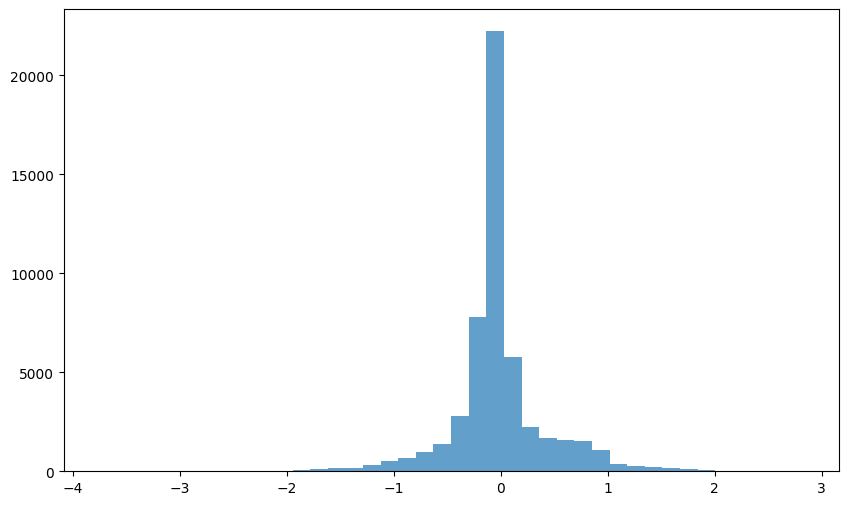

In [57]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

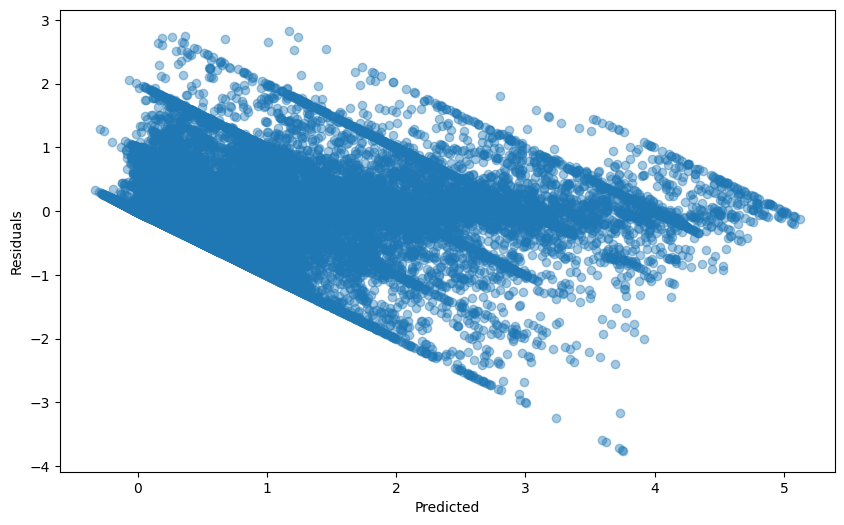

In [58]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

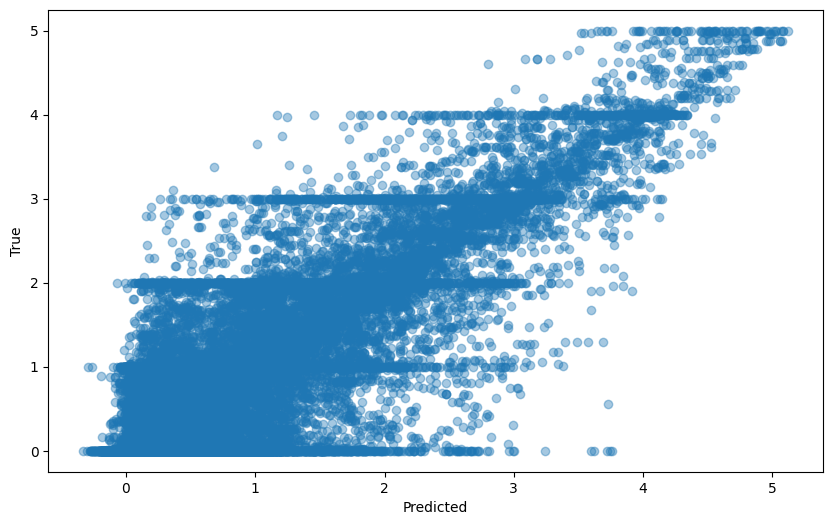

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")